In [30]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

from transformers import BertTokenizer, BertForQuestionAnswering, BertConfig

from captum.attr import visualization as viz
from captum.attr import LayerConductance, LayerIntegratedGradients

In [31]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [43]:
from transformers import RobertaForSequenceClassification
from transformers import RobertaTokenizer
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import BertForQuestionAnswering

model = BertForQuestionAnswering.from_pretrained("bert-base-uncased")

# Le reste de votre code reste inchangé


model_path = "./model_roberta"
tokenizer_path = "./tokenizer_roberta"

#model = RobertaForSequenceClassification.from_pretrained(model_path)
#model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)
model.to(device)
model.eval()
model.zero_grad()

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
#tokenizer = RobertaTokenizer.from_pretrained(tokenizer_path)

Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [44]:
# Comparaison des chemins des modèles et des tokenizers
print("Model path:", model_path)
print("Tokenizer path:", tokenizer_path)

# Comparaison des vocabulaires des tokenizers
print("Training Tokenizer Vocab Size:", tokenizer.vocab_size)
print("Loaded Tokenizer Vocab Size:", len(tokenizer.get_vocab()))

# Comparaison des paramètres du tokenizer
print("Tokenizer Special Tokens:", tokenizer.special_tokens_map)
print("Tokenizer Max Length:", tokenizer.model_max_length)


Model path: ./model_roberta
Tokenizer path: ./tokenizer_roberta
Training Tokenizer Vocab Size: 30522
Loaded Tokenizer Vocab Size: 30522
Tokenizer Special Tokens: {'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}
Tokenizer Max Length: 512


In [46]:
def predict(inputs, token_type_ids=None, position_ids=None, attention_mask=None):
    output = model(inputs, token_type_ids=token_type_ids,
                 position_ids=position_ids, attention_mask=attention_mask)
    return output.start_logits, output.end_logits

In [47]:
def squad_pos_forward_func(inputs, token_type_ids=None, position_ids=None, attention_mask=None, position=0):
    pred = predict(inputs,
                   token_type_ids=token_type_ids,
                   position_ids=position_ids,
                   attention_mask=attention_mask)
    pred = pred[position]
    return pred.max(1).values

In [48]:
ref_token_id = tokenizer.pad_token_id # A token used for generating token reference
sep_token_id = tokenizer.sep_token_id # A token used as a separator between question and text and it is also added to the end of the text.
cls_token_id = tokenizer.cls_token_id # A token used for prepending to the concatenated question-text word sequence

In [49]:
def construct_input_ref_pair(question, text, ref_token_id, sep_token_id, cls_token_id):
    question_ids = tokenizer.encode(question, add_special_tokens=False)
    text_ids = tokenizer.encode(text, add_special_tokens=False)

    # construct input token ids
    input_ids = [cls_token_id] + question_ids + [sep_token_id] + text_ids + [sep_token_id]

    # construct reference token ids 
    ref_input_ids = [cls_token_id] + [ref_token_id] * len(question_ids) + [sep_token_id] + \
        [ref_token_id] * len(text_ids) + [sep_token_id]

    return torch.tensor([input_ids], device=device), torch.tensor([ref_input_ids], device=device), len(question_ids)

def construct_input_ref_token_type_pair(input_ids, sep_ind=0):
    seq_len = input_ids.size(1)
    token_type_ids = torch.tensor([[0 if i <= sep_ind else 1 for i in range(seq_len)]], device=device)
    ref_token_type_ids = torch.zeros_like(token_type_ids, device=device)# * -1
    return token_type_ids, ref_token_type_ids

def construct_input_ref_pos_id_pair(input_ids):
    seq_length = input_ids.size(1)
    position_ids = torch.arange(seq_length, dtype=torch.long, device=device)
    # we could potentially also use random permutation with `torch.randperm(seq_length, device=device)`
    ref_position_ids = torch.zeros(seq_length, dtype=torch.long, device=device)

    position_ids = position_ids.unsqueeze(0).expand_as(input_ids)
    ref_position_ids = ref_position_ids.unsqueeze(0).expand_as(input_ids)
    return position_ids, ref_position_ids
    
def construct_attention_mask(input_ids):
    return torch.ones_like(input_ids)

def construct_whole_bert_embeddings(input_ids, ref_input_ids, \
                                    token_type_ids=None, ref_token_type_ids=None, \
                                    position_ids=None, ref_position_ids=None):
    input_embeddings = model.bert.embeddings(input_ids, token_type_ids=token_type_ids, position_ids=position_ids)
    ref_input_embeddings = model.bert.embeddings(ref_input_ids, token_type_ids=ref_token_type_ids, position_ids=ref_position_ids)
    
    return input_embeddings, ref_input_embeddings

In [50]:
question, text = "What is important to us?", "It is important to us to include, empower and support humans of all kinds."

In [51]:
input_ids, ref_input_ids, sep_id = construct_input_ref_pair(question, text, ref_token_id, sep_token_id, cls_token_id)
token_type_ids, ref_token_type_ids = construct_input_ref_token_type_pair(input_ids, sep_id)
position_ids, ref_position_ids = construct_input_ref_pos_id_pair(input_ids)
attention_mask = construct_attention_mask(input_ids)

indices = input_ids[0].detach().tolist()
all_tokens = tokenizer.convert_ids_to_tokens(indices)

In [52]:
print("Input IDs shape:", input_ids.shape)
print("Input IDs:", input_ids)
print("Token Type IDs shape:", token_type_ids.shape)
print("Token Type IDs:", token_type_ids)
print("Position IDs shape:", position_ids.shape)
print("Position IDs:", position_ids)
print("Attention Mask shape:", attention_mask.shape)
print("Attention Mask:", attention_mask)

Input IDs shape: torch.Size([1, 26])
Input IDs: tensor([[  101,  2054,  2003,  2590,  2000,  2149,  1029,   102,  2009,  2003,
          2590,  2000,  2149,  2000,  2421,  1010,  7861, 11452,  1998,  2490,
          4286,  1997,  2035,  7957,  1012,   102]])
Token Type IDs shape: torch.Size([1, 26])
Token Type IDs: tensor([[0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1]])
Position IDs shape: torch.Size([1, 26])
Position IDs: tensor([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
         18, 19, 20, 21, 22, 23, 24, 25]])
Attention Mask shape: torch.Size([1, 26])
Attention Mask: tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1]])


In [53]:
ground_truth = 'to include, empower and support humans of all kinds'

ground_truth_tokens = tokenizer.encode(ground_truth, add_special_tokens=False)
ground_truth_end_ind = indices.index(ground_truth_tokens[-1])
ground_truth_start_ind = ground_truth_end_ind - len(ground_truth_tokens) + 1

In [54]:
start_scores, end_scores = predict(input_ids, \
                                   token_type_ids=token_type_ids, \
                                   position_ids=position_ids, \
                                   attention_mask=attention_mask)


print('Question: ', question)
print('Predicted Answer: ', ' '.join(all_tokens[torch.argmax(start_scores) : torch.argmax(end_scores)+1]))

Question:  What is important to us?
Predicted Answer:  


In [55]:
lig = LayerIntegratedGradients(squad_pos_forward_func, model.bert.embeddings)

attributions_start, delta_start = lig.attribute(inputs=input_ids,
                                  baselines=ref_input_ids,
                                  additional_forward_args=(token_type_ids, position_ids, attention_mask, 0),
                                  return_convergence_delta=True)
attributions_end, delta_end = lig.attribute(inputs=input_ids, baselines=ref_input_ids,
                                additional_forward_args=(token_type_ids, position_ids, attention_mask, 1),
                                return_convergence_delta=True)

In [56]:
def summarize_attributions(attributions):
    attributions = attributions.sum(dim=-1).squeeze(0)
    attributions = attributions / torch.norm(attributions)
    return attributions

In [57]:
attributions_start_sum = summarize_attributions(attributions_start)
attributions_end_sum = summarize_attributions(attributions_end)

In [58]:
# storing couple samples in an array for visualization purposes
start_position_vis = viz.VisualizationDataRecord(
                        attributions_start_sum,
                        torch.max(torch.softmax(start_scores[0], dim=0)),
                        torch.argmax(start_scores),
                        torch.argmax(start_scores),
                        str(ground_truth_start_ind),
                        attributions_start_sum.sum(),       
                        all_tokens,
                        delta_start)

end_position_vis = viz.VisualizationDataRecord(
                        attributions_end_sum,
                        torch.max(torch.softmax(end_scores[0], dim=0)),
                        torch.argmax(end_scores),
                        torch.argmax(end_scores),
                        str(ground_truth_end_ind),
                        attributions_end_sum.sum(),       
                        all_tokens,
                        delta_end)

print('\033[1m', 'Visualizations For Start Position', '\033[0m')
viz.visualize_text([start_position_vis])

print('\033[1m', 'Visualizations For End Position', '\033[0m')
viz.visualize_text([end_position_vis])

 Visualizations For Start Position 


 Visualizations For End Position 


In [59]:
lig2 = LayerIntegratedGradients(squad_pos_forward_func, \
                                [model.bert.embeddings.word_embeddings, \
                                 model.bert.embeddings.token_type_embeddings, \
                                 model.bert.embeddings.position_embeddings])

attributions_start = lig2.attribute(inputs=(input_ids, token_type_ids, position_ids),
                                  baselines=(ref_input_ids, ref_token_type_ids, ref_position_ids),
                                  additional_forward_args=(attention_mask, 0))
attributions_end = lig2.attribute(inputs=(input_ids, token_type_ids, position_ids),
                                  baselines=(ref_input_ids, ref_token_type_ids, ref_position_ids),
                                  additional_forward_args=(attention_mask, 1))

attributions_start_word = summarize_attributions(attributions_start[0])
attributions_end_word = summarize_attributions(attributions_end[0])

attributions_start_token_type = summarize_attributions(attributions_start[1])
attributions_end_token_type = summarize_attributions(attributions_end[1])

attributions_start_position = summarize_attributions(attributions_start[2])
attributions_end_position = summarize_attributions(attributions_end[2])

/Applications/anaconda3/envs/BERT-test/lib/python3.10/site-packages/captum/attr/_core/layer/layer_integrated_gradients.py:101: UserWarning: Multiple layers provided. Please ensure that each layer is**not** solely dependent on the outputs ofanother layer. Please refer to the documentation for moredetail.
  warnings.warn(


In [60]:
def get_topk_attributed_tokens(attrs, k=5):
    values, indices = torch.topk(attrs, k)
    top_tokens = [all_tokens[idx] for idx in indices]
    return top_tokens, values, indices

In [61]:
top_words_start, top_words_val_start, top_word_ind_start = get_topk_attributed_tokens(attributions_start_word)
top_words_end, top_words_val_end, top_words_ind_end = get_topk_attributed_tokens(attributions_end_word)

top_token_type_start, top_token_type_val_start, top_token_type_ind_start = get_topk_attributed_tokens(attributions_start_token_type)
top_token_type_end, top_token_type_val_end, top_token_type_ind_end = get_topk_attributed_tokens(attributions_end_token_type)

top_pos_start, top_pos_val_start, pos_ind_start = get_topk_attributed_tokens(attributions_start_position)
top_pos_end, top_pos_val_end, pos_ind_end = get_topk_attributed_tokens(attributions_end_position)

df_start = pd.DataFrame({'Word(Index), Attribution': ["{} ({}), {}".format(word, pos, round(val.item(),2)) for word, pos, val in zip(top_words_start, top_word_ind_start, top_words_val_start)],
                   'Token Type(Index), Attribution': ["{} ({}), {}".format(ttype, pos, round(val.item(),2)) for ttype, pos, val in zip(top_token_type_start, top_token_type_ind_start, top_words_val_start)],
                   'Position(Index), Attribution': ["{} ({}), {}".format(position, pos, round(val.item(),2)) for position, pos, val in zip(top_pos_start, pos_ind_start, top_pos_val_start)]})
df_start.style.apply(['cell_ids: False'])

df_end = pd.DataFrame({'Word(Index), Attribution': ["{} ({}), {}".format(word, pos, round(val.item(),2)) for word, pos, val in zip(top_words_end, top_words_ind_end, top_words_val_end)],
                   'Token Type(Index), Attribution': ["{} ({}), {}".format(ttype, pos, round(val.item(),2)) for ttype, pos, val in zip(top_token_type_end, top_token_type_ind_end, top_words_val_end)],
                   'Position(Index), Attribution': ["{} ({}), {}".format(position, pos, round(val.item(),2)) for position, pos, val in zip(top_pos_end, pos_ind_end, top_pos_val_end)]})
df_end.style.apply(['cell_ids: False'])

['{}({})'.format(token, str(i)) for i, token in enumerate(all_tokens)]

['[CLS](0)',
 'what(1)',
 'is(2)',
 'important(3)',
 'to(4)',
 'us(5)',
 '?(6)',
 '[SEP](7)',
 'it(8)',
 'is(9)',
 'important(10)',
 'to(11)',
 'us(12)',
 'to(13)',
 'include(14)',
 ',(15)',
 'em(16)',
 '##power(17)',
 'and(18)',
 'support(19)',
 'humans(20)',
 'of(21)',
 'all(22)',
 'kinds(23)',
 '.(24)',
 '[SEP](25)']

In [62]:
df_start

,"Word(Index), Attribution","Token Type(Index), Attribution","Position(Index), Attribution"
0,". (24), 0.88",". (24), 0.88",". (24), 0.92"
1,"kinds (23), 0.19","[SEP] (7), 0.19","kinds (23), 0.25"
2,"##power (17), 0.15","[SEP] (25), 0.15","important (10), 0.1"
3,"em (16), 0.15","of (21), 0.15","it (8), 0.09"
4,"important (10), 0.09","and (18), 0.09","is (9), 0.09"


In [63]:
df_end

,"Word(Index), Attribution","Token Type(Index), Attribution","Position(Index), Attribution"
0,"? (6), 0.53","[SEP] (7), 0.53","? (6), 0.82"
1,"it (8), 0.3","[SEP] (25), 0.3","is (2), 0.2"
2,"us (5), 0.23","kinds (23), 0.23","what (1), 0.16"
3,"us (12), 0.23","important (3), 0.23","it (8), 0.12"
4,". (24), 0.22","to (4), 0.22","[SEP] (7), 0.12"


In [64]:
def squad_pos_forward_func2(input_emb, attention_mask=None, position=0):
    pred = model(inputs_embeds=input_emb, attention_mask=attention_mask, )
    pred = pred[position]
    return pred.max(1).values

In [65]:
layer_attrs_start = []
layer_attrs_end = []

# The token that we would like to examine separately.
token_to_explain = 23 # the index of the token that we would like to examine more thoroughly
layer_attrs_start_dist = []
layer_attrs_end_dist = []

input_embeddings, ref_input_embeddings = construct_whole_bert_embeddings(input_ids, ref_input_ids, \
                                         token_type_ids=token_type_ids, ref_token_type_ids=ref_token_type_ids, \
                                         position_ids=position_ids, ref_position_ids=ref_position_ids)

for i in range(model.config.num_hidden_layers):
    lc = LayerConductance(squad_pos_forward_func2, model.bert.encoder.layer[i])
    layer_attributions_start = lc.attribute(inputs=input_embeddings, baselines=ref_input_embeddings, additional_forward_args=(attention_mask, 0))
    layer_attributions_end = lc.attribute(inputs=input_embeddings, baselines=ref_input_embeddings, additional_forward_args=(attention_mask, 1))
    layer_attrs_start.append(summarize_attributions(layer_attributions_start).cpu().detach().tolist())
    layer_attrs_end.append(summarize_attributions(layer_attributions_end).cpu().detach().tolist())

    # storing attributions of the token id that we would like to examine in more detail in token_to_explain
    layer_attrs_start_dist.append(layer_attributions_start[0,token_to_explain,:].cpu().detach().tolist())
    layer_attrs_end_dist.append(layer_attributions_end[0,token_to_explain,:].cpu().detach().tolist())

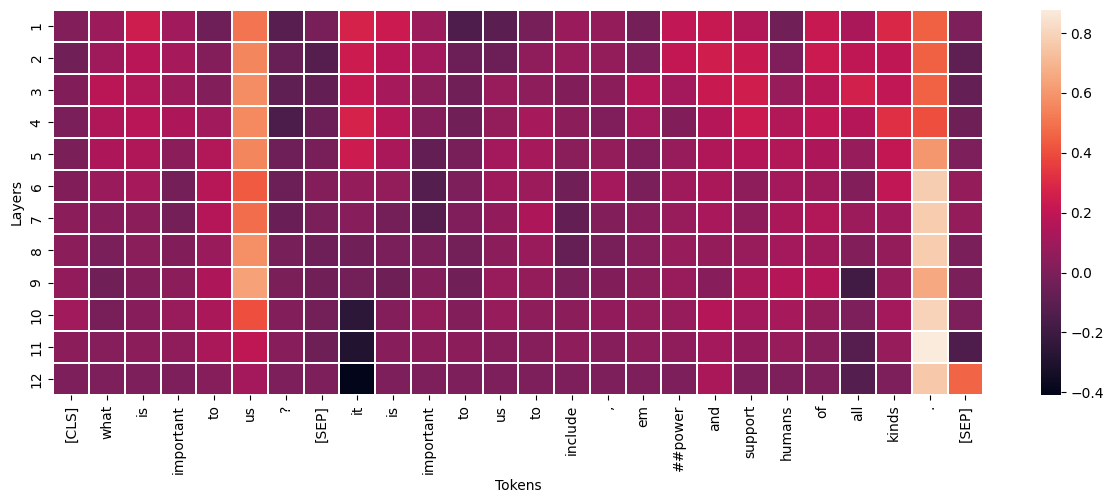

In [66]:
fig, ax = plt.subplots(figsize=(15,5))
xticklabels=all_tokens
yticklabels=list(range(1,13))
ax = sns.heatmap(np.array(layer_attrs_start), xticklabels=xticklabels, yticklabels=yticklabels, linewidth=0.2)
plt.xlabel('Tokens')
plt.ylabel('Layers')
plt.show()

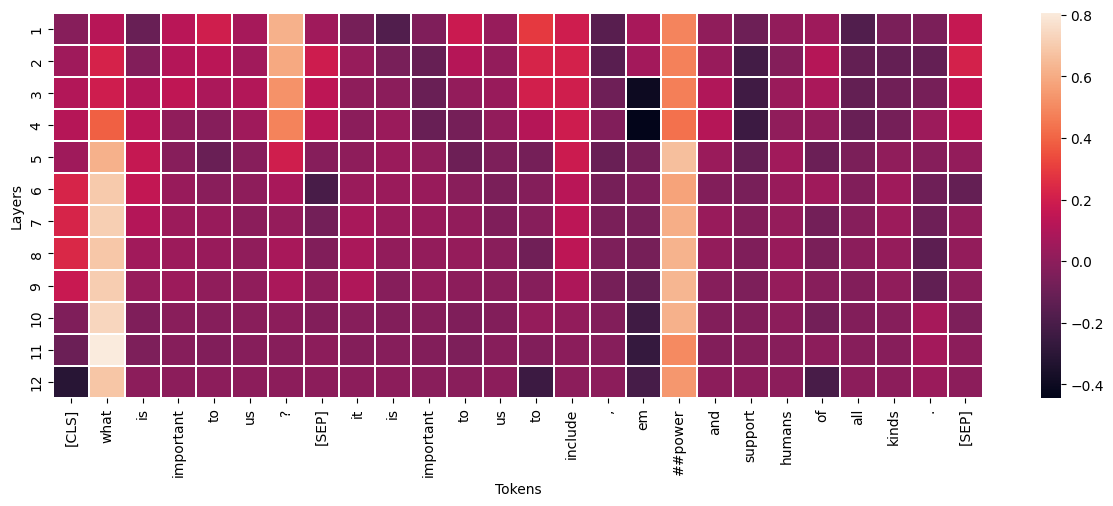

In [67]:
fig, ax = plt.subplots(figsize=(15,5))

xticklabels=all_tokens
yticklabels=list(range(1,13))
ax = sns.heatmap(np.array(layer_attrs_end), xticklabels=xticklabels, yticklabels=yticklabels, linewidth=0.2) #, annot=True
plt.xlabel('Tokens')
plt.ylabel('Layers')

plt.show()

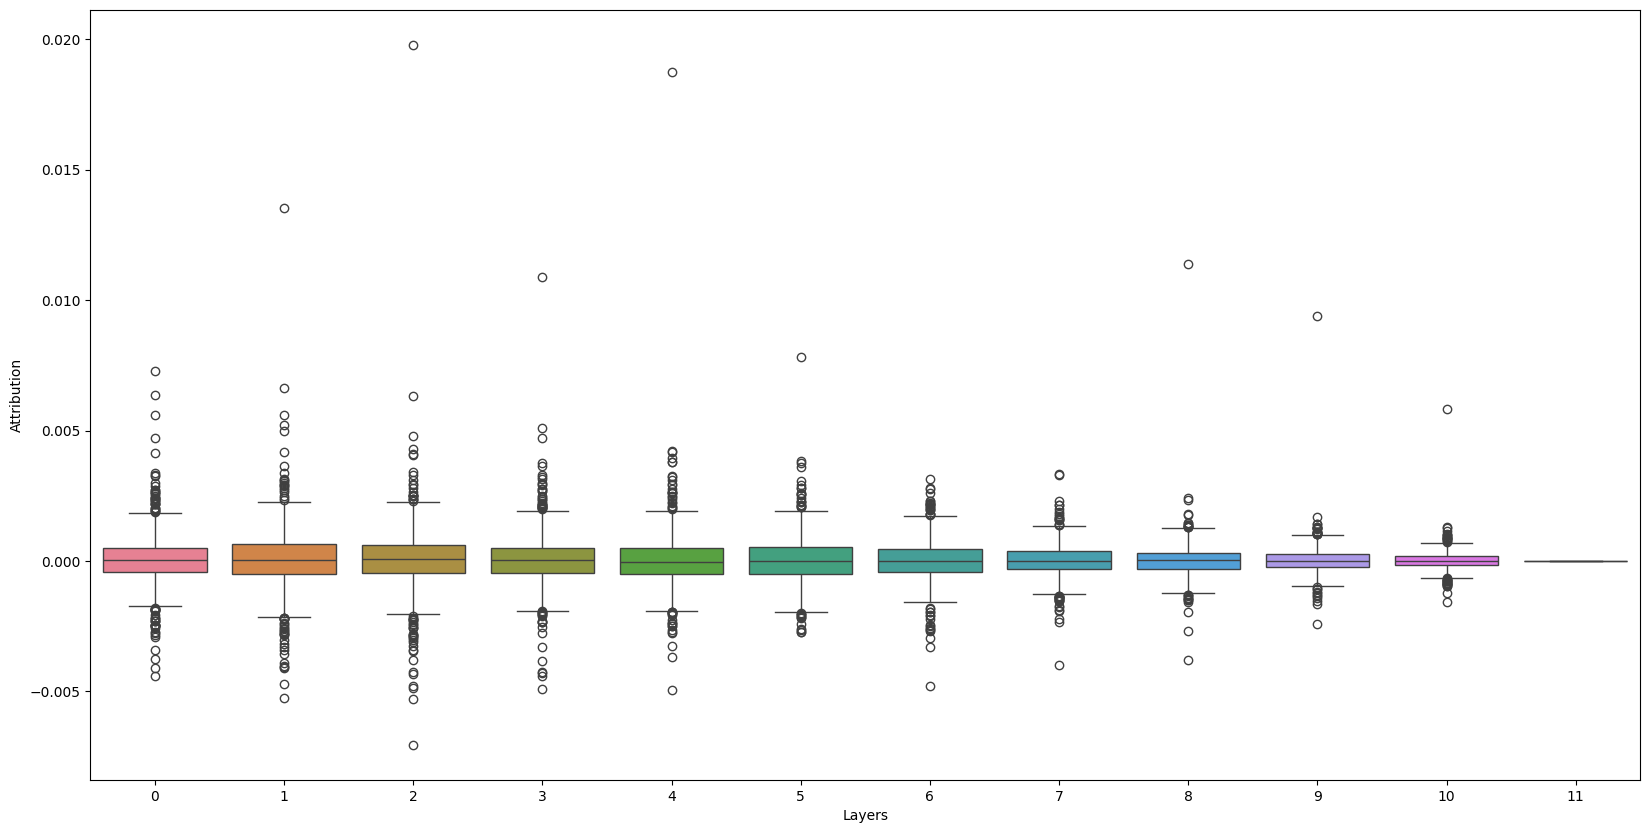

In [68]:
fig, ax = plt.subplots(figsize=(20,10))
ax = sns.boxplot(data=layer_attrs_start_dist)
plt.xlabel('Layers')
plt.ylabel('Attribution')
plt.show()

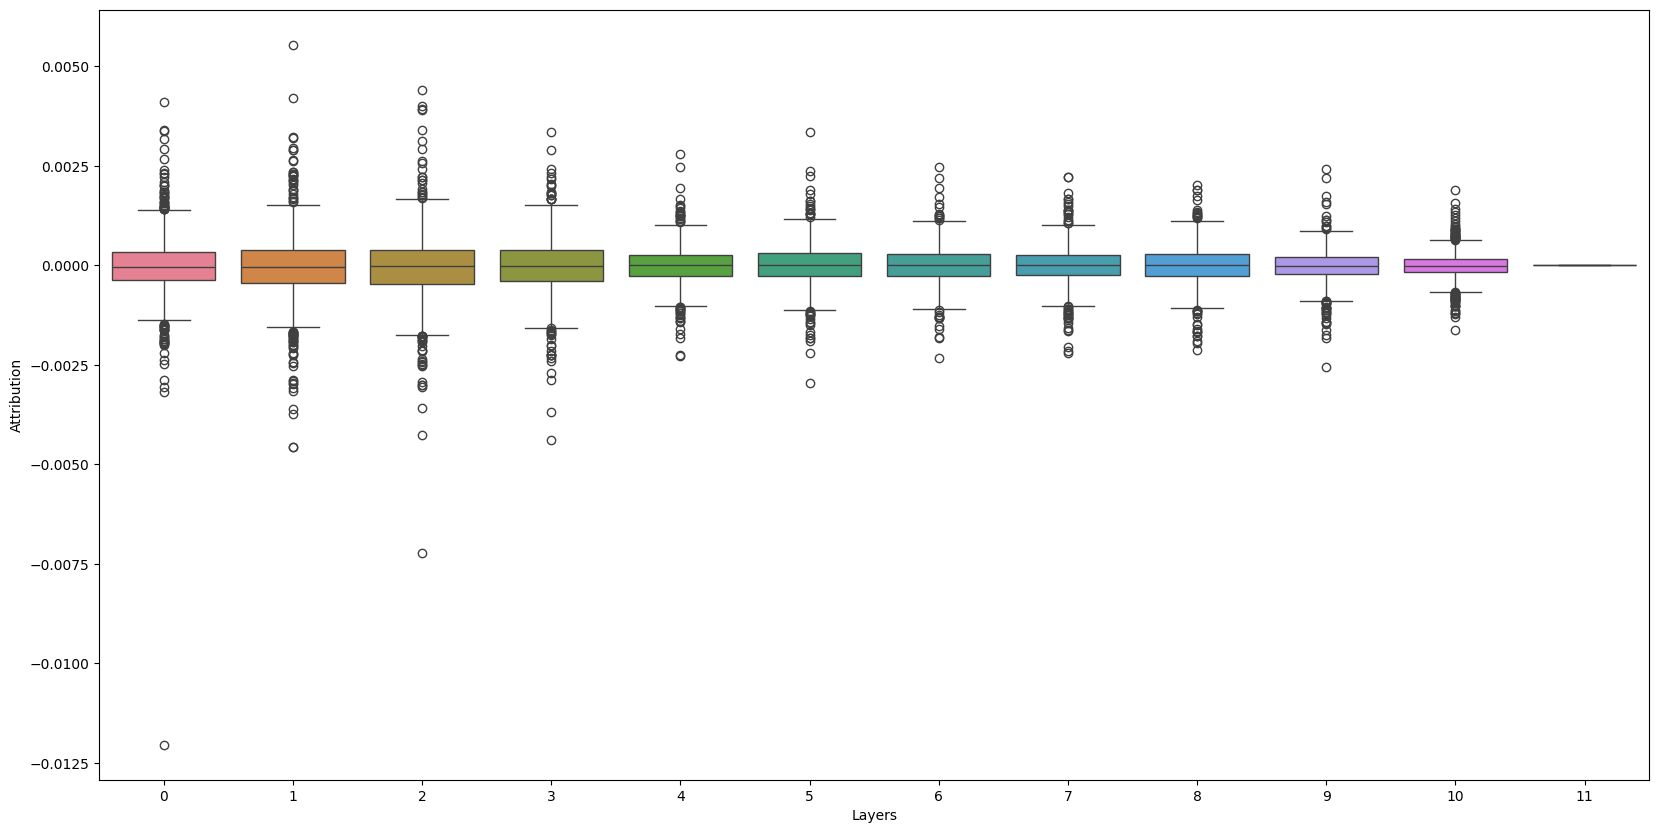

In [69]:
fig, ax = plt.subplots(figsize=(20,10))
ax = sns.boxplot(data=layer_attrs_end_dist)
plt.xlabel('Layers')
plt.ylabel('Attribution')
plt.show()

In [70]:
def pdf_attr(attrs, bins=100):
    return np.histogram(attrs, bins=bins, density=True)[0]


In [71]:
layer_attrs_end_pdf = map(lambda layer_attrs_end_dist: pdf_attr(layer_attrs_end_dist), layer_attrs_end_dist)
layer_attrs_end_pdf = np.array(list(layer_attrs_end_pdf))

# summing attribution along embedding diemension for each layer
# size: #layers
attr_sum = np.array(layer_attrs_end_dist).sum(-1)

# size: #layers
layer_attrs_end_pdf_norm = np.linalg.norm(layer_attrs_end_pdf, axis=-1, ord=1)

#size: #bins x #layers
layer_attrs_end_pdf = np.transpose(layer_attrs_end_pdf)

#size: #bins x #layers
layer_attrs_end_pdf = np.divide(layer_attrs_end_pdf, layer_attrs_end_pdf_norm, where=layer_attrs_end_pdf_norm!=0)

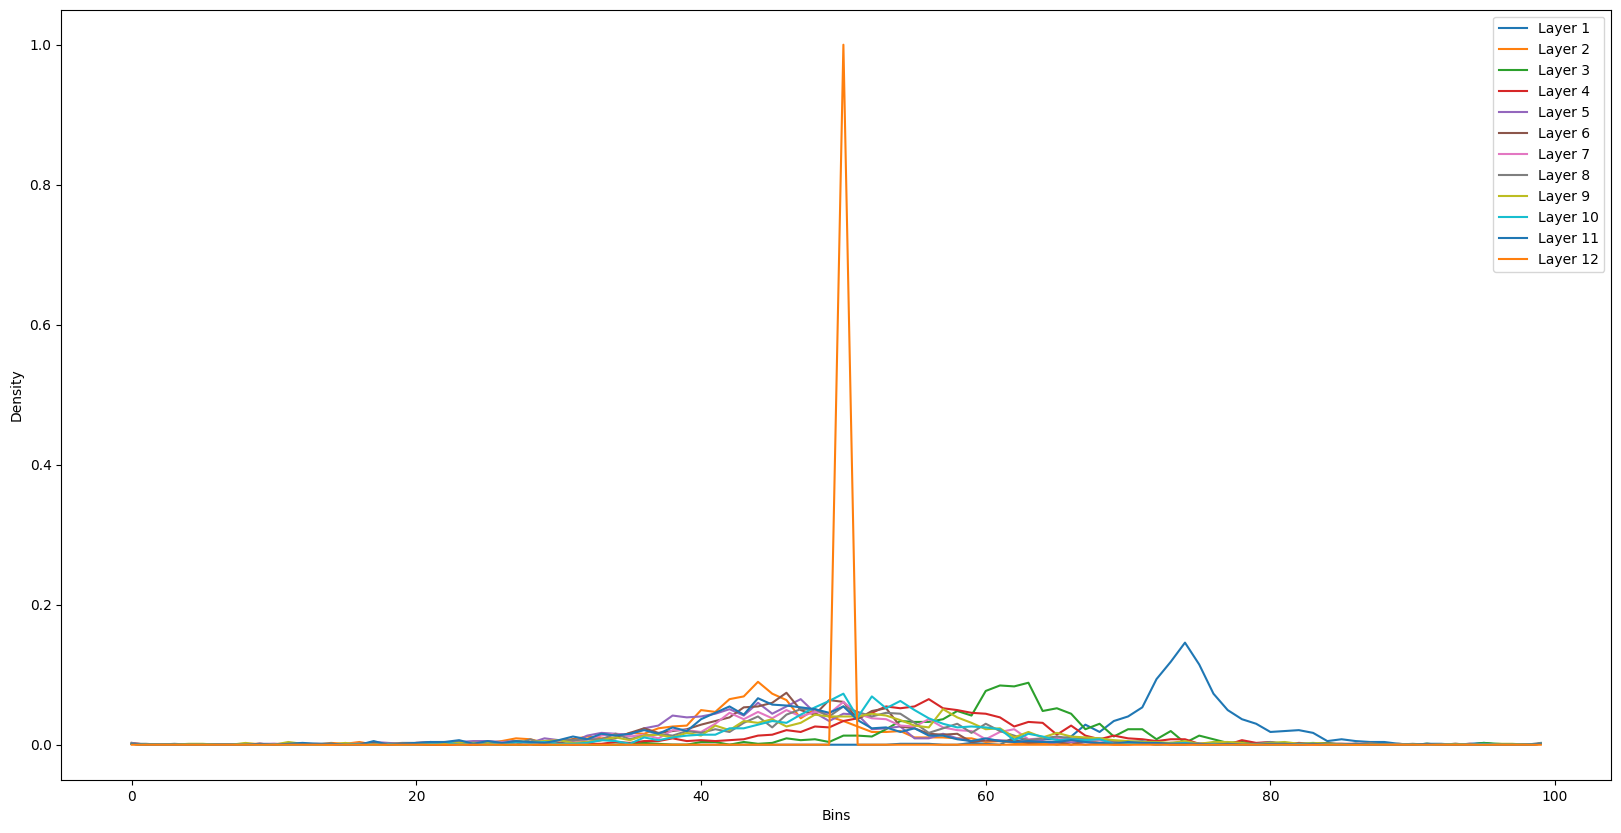

In [72]:
fig, ax = plt.subplots(figsize=(20,10))
plt.plot(layer_attrs_end_pdf)
plt.xlabel('Bins')
plt.ylabel('Density')
plt.legend(['Layer '+ str(i) for i in range(1,13)])
plt.show()

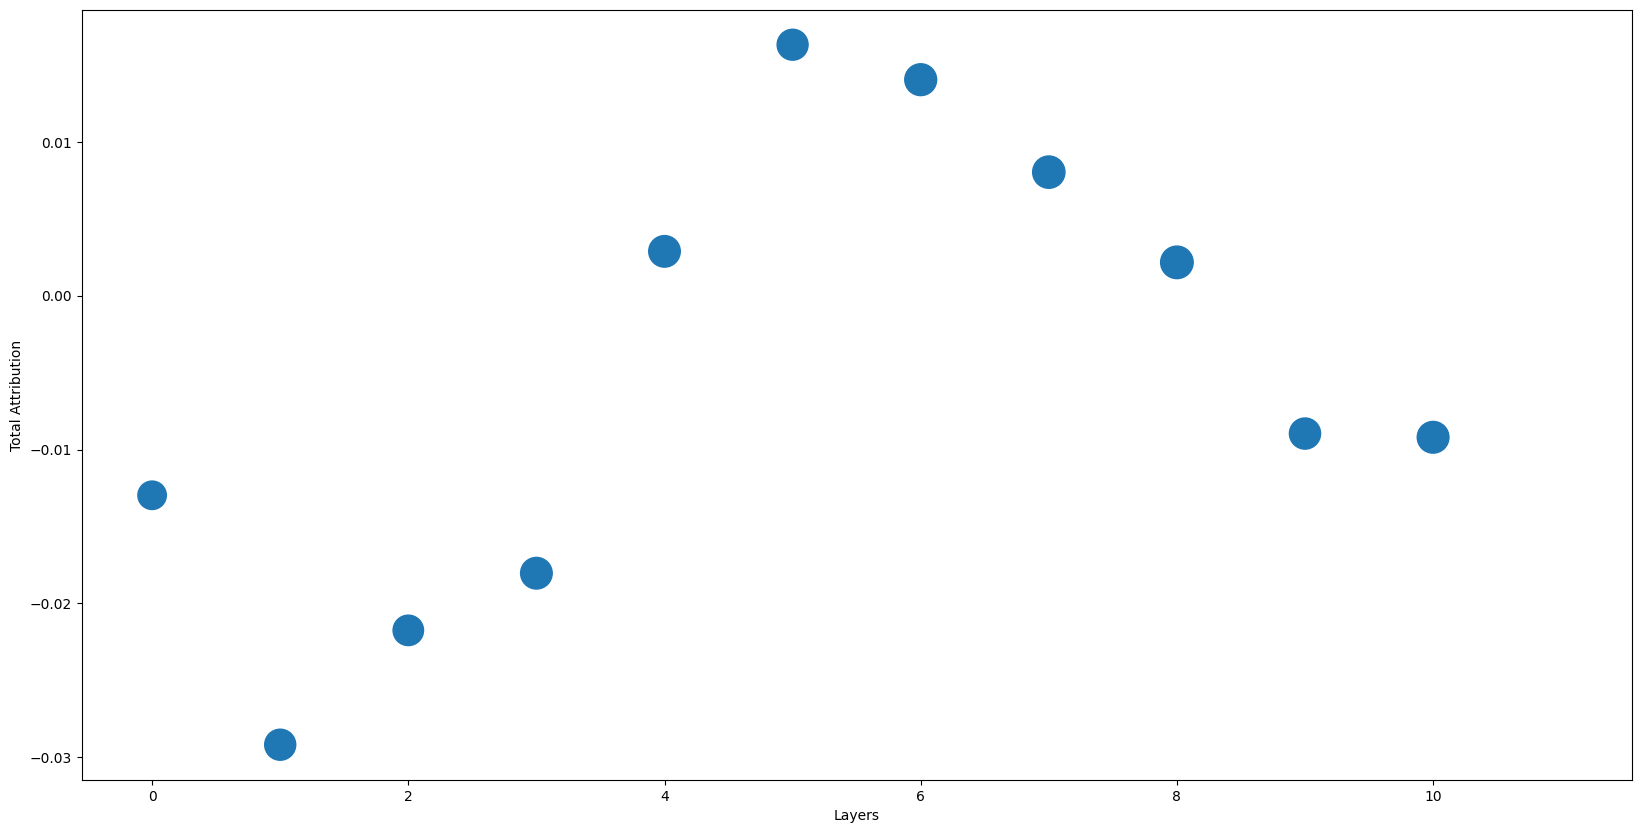

In [73]:
fig, ax = plt.subplots(figsize=(20,10))

# replacing 0s with 1s. np.log(1) = 0 and np.log(0) = -inf
layer_attrs_end_pdf[layer_attrs_end_pdf == 0] = 1
layer_attrs_end_pdf_log = np.log2(layer_attrs_end_pdf)

# size: #layers
entropies= -(layer_attrs_end_pdf * layer_attrs_end_pdf_log).sum(0)

plt.scatter(np.arange(12), attr_sum, s=entropies * 100)
plt.xlabel('Layers')
plt.ylabel('Total Attribution')
plt.show()